<a href="https://colab.research.google.com/github/tcharos/AIDL_B02-Advanced-Topics-in-Deep-Learning/blob/main/AIDL_B02_AdvancedTopicsInDeepLearning_SpaceInvaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/tcharos/AIDL_B02-Advanced-Topics-in-Deep-Learning/blob/main/AIDL_B02_AdvancedTopicsInDeepLearning_SpaceInvaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Project Base: DQN Variants for ALE/SpaceInvaders-v5

This notebook strictly implements the project's requirements for the **`ALE/SpaceInvaders-v5`** environment with 4-frame stacking and CNN architecture.

**Key Requirements Met:**
* **Environment:** `ALE/SpaceInvaders-v5` [cite: 11]
* **Action Space:** 6 actions [cite: 13, 21]
* **State:** 4 stacked input frames [cite: 19]

**To run an implementation:**
1.  Change the `CONFIG['MODE']` variable below to one of: **`SimpleDQN`**, **`DoubleDQN`**, or **`DuelingDQN`**.
2.  Adjust hyperparameters (`LR`, `EPS_DECAY`, etc.) in the `CONFIG` dictionary if needed.
3.  Run all cells.

## 1. Setup and Configuration

In [78]:
!pip install "gymnasium[atari,accept-rom-license,other]" ale-py
!pip install pyvirtualdisplay
!apt-get install -y xvfb x11-utils
!pip install shimmy imageio-ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [79]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
import ale_py

import gc
import psutil
import os
import glob

# Tools for video display
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from base64 import b64encode

In [80]:
# ----------------- GLOBAL CONFIGURATION -----------------
CONFIG = {
    "ENV_ID": 'ALE/SpaceInvaders-v5',
    "SEED": 2,
    "MODE": "SimpleDQN", # 'SimpleDQN', 'DoubleDQN', 'DuelingDQN'
    "INPUT_SHAPE": (4, 84, 84), # 4 stacked frames, resized to 84x84
    "BUFFER_SIZE": int(5e4), # also checked 1e5, 1e4 (10000), 5e3 (5000), 7.5e3 (7500)
    "BATCH_SIZE": 64, # Reduced batch size
    "GAMMA": 0.99, # Prioritize long-term cumulative reward
    "TAU": 1e-3, # Soft Update Rate
    "LR": 2e-4, # Also tried 1e-4, 5e-5. Lower learning rate --> stable convergence
    "UPDATE_EVERY": 4, # Learn frequency
    "TARGET_UPDATE_FREQ": 1000, # Also tried 1000
    "N_EPISODES": 5000,
    "EPS_START": 1.0, # Initial probability of choosing a random action (exploration) --> fully exploring the environment to gather initial experiences
    "EPS_END": 0.01, # Also chekced 0.01. Minimum probability of choosing a random action.
    "EPS_DECAY": 0.9996, # Also checked 0.999, 0.995
    "USE_GOOGLE_DRIVE": True,
    "CHECKPOINT_FREQ": 400,
    "GOAL_SCORE": 400.0
}

CONFIG_DUELING = {
    "ENV_ID": 'ALE/SpaceInvaders-v5',
    "SEED": 999,
    "MODE": "DuelingDQN",
    "INPUT_SHAPE": (4, 84, 84),
    "BUFFER_SIZE": int(5e4),       # 50k buffer
    "BATCH_SIZE": 64,               # Large batches
    "GAMMA": 0.99,
    "TAU": 1e-3,
    "LR": 2.5e-4,                   # Increased from 1.5e-4 (more aggressive learning)
    "UPDATE_EVERY": 4,
    "TARGET_UPDATE_FREQ": 1000,
    "N_EPISODES": 5000,            # Increased to 10k (need more time)
    "EPS_START": 1.0,
    "EPS_END": 0.01,
    "EPS_DECAY": 0.9996,            # Slightly faster than 0.9997
    "USE_GOOGLE_DRIVE": True,
    "CHECKPOINT_FREQ": 100,
    "GOAL_SCORE": 400.0
}

CONFIG_DOUBLE = {
    "ENV_ID": 'ALE/SpaceInvaders-v5',
    "SEED": 789,
    "MODE": "DoubleDQN",
    "INPUT_SHAPE": (4, 84, 84),
    "BUFFER_SIZE": int(5e4),
    "BATCH_SIZE": 64,
    "GAMMA": 0.99,
    "TAU": 1e-3,
    "LR": 2.5e-4,                # Same as DuelingDQN
    "UPDATE_EVERY": 4,
    "TARGET_UPDATE_FREQ": 1000,
    "N_EPISODES": 5000,          # Slightly less than Dueling
    "EPS_START": 1.0,
    "EPS_END": 0.01,
    "EPS_DECAY": 0.9996,
    "USE_GOOGLE_DRIVE": True,
    "CHECKPOINT_FREQ": 100,
    "GOAL_SCORE": 400.0
}
# --------------------------------------------------------

gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random.seed(CONFIG['SEED'])
np.random.seed(CONFIG['SEED'])
torch.manual_seed(CONFIG['SEED'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['SEED'])

print(f"Using device: {device}")
print(f"Current DQN Mode: {CONFIG['MODE']}")

Using device: cuda:0
Current DQN Mode: SimpleDQN


In [81]:
# Print configuration
def print_config():
    print("\n" + "="*70)
    print("CURRENT CONFIGURATION - SimpleDQN Aggressive")
    print("="*70)
    print(f"Environment:          {CONFIG['ENV_ID']}")
    print(f"Seed:                 {CONFIG['SEED']}")
    print(f"Mode:                 {CONFIG['MODE']}")
    print(f"Buffer Size:          {CONFIG['BUFFER_SIZE']:,} experiences")
    print(f"Batch Size:           {CONFIG['BATCH_SIZE']}")
    print(f"Learning Rate:        {CONFIG['LR']}")
    print(f"Gamma:                {CONFIG['GAMMA']}")
    print(f"Update Every:         {CONFIG['UPDATE_EVERY']} steps")
    print(f"Target Update Freq:   {CONFIG['TARGET_UPDATE_FREQ']} steps")
    print(f"Episodes:             {CONFIG['N_EPISODES']}")
    print(f"Epsilon Start:        {CONFIG['EPS_START']}")
    print(f"Epsilon End:          {CONFIG['EPS_END']}")
    print(f"Epsilon Decay:        {CONFIG['EPS_DECAY']}")
    print(f"Checkpoint Freq:      {CONFIG['CHECKPOINT_FREQ']} episodes")
    print("="*70)

In [82]:
if CONFIG['USE_GOOGLE_DRIVE']:
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/MyDrive/DQN_Checkpoints'
    print("✓ Google Drive mounted - checkpoints will be saved to Drive")
else:
    checkpoint_dir = './checkpoints'  # Local directory
    print("✓ Using local storage - checkpoints will be saved locally")

os.makedirs(checkpoint_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted - checkpoints will be saved to Drive


## 2. Environment Initialization
We use **`AtariPreprocessing`** to handle resizing/cropping to 84x84 and grayscale conversion. **`FrameStack`** then stacks 4 consecutive frames, fulfilling the requirements for the state space[cite: 19, 20].

In [83]:
def make_atari_env(env_id, seed):
    """Creates and wraps the Atari environment with standard preprocessing and 4-frame stacking."""
    # 1. Base Environment (Using the required ID [cite: 11])
    env = gym.make(env_id)

    # 2. Atari Preprocessing: Resizes to 84x84, grayscale, handles max-pooling/skip.
    # Frame skip is set to 1 here because the ALE/SpaceInvaders-v5 environment generally handles skips
    # implicitly, or we rely on the standard wrappers' internal logic for compatibility.
    env = AtariPreprocessing(env, grayscale_obs=True, terminal_on_life_loss=True, frame_skip=1, screen_size=84)

    # 3. Frame Stacking (Creates the (4, 84, 84) state [cite: 19])
    env = FrameStackObservation(env, stack_size=4)

    # Set seed on the final environment
    if seed is not None:
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

    return env

env = make_atari_env(CONFIG['ENV_ID'], CONFIG['SEED'])
action_size = env.action_space.n
state_shape = env.observation_space.shape

print(f'Final State shape (Stacked Frames): {state_shape}')
print(f'Number of available actions (SpaceInvaders): {action_size}') # Confirms 6 actions [cite: 13, 21]

Final State shape (Stacked Frames): (4, 84, 84)
Number of available actions (SpaceInvaders): 6


## 3. Q-Network Architecture
The network uses a CNN architecture  to process the high-dimensional image input, supporting Dueling components via a flag.

In [84]:
class QNetwork(nn.Module):
    """Enhanced Q-Network with BatchNorm - supports both Standard and Dueling architectures."""

    def __init__(self, state_shape, action_size, seed, dueling=False):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.dueling = dueling
        in_channels = state_shape[0]  # 4 stacked frames

        # Enhanced CNN layers with BatchNorm
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)  # Increased to 128
        self.bn3 = nn.BatchNorm2d(128)

        # Calculate fc_input_size dynamically
        dummy_input = torch.zeros(1, *state_shape)
        x = self._forward_conv(dummy_input)
        self.fc_input_size = x.view(1, -1).size(1)

        if self.dueling:
            # Value stream (estimates state value)
            self.fc_v1 = nn.Linear(self.fc_input_size, 512)
            self.fc_v2 = nn.Linear(512, 256)
            self.fc_v3 = nn.Linear(256, 1)

            # Advantage stream (estimates action advantages)
            self.fc_a1 = nn.Linear(self.fc_input_size, 512)
            self.fc_a2 = nn.Linear(512, 256)
            self.fc_a3 = nn.Linear(256, action_size)

            self.dropout = nn.Dropout(0.1)
        else:
            # Standard Q-value stream
            self.fc1 = nn.Linear(self.fc_input_size, 512)
            self.fc2 = nn.Linear(512, 256)
            self.fc3 = nn.Linear(256, action_size)

            self.dropout = nn.Dropout(0.1)

    def _forward_conv(self, x):
        """Forward pass through convolutional layers with BatchNorm."""
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return x.view(x.size(0), -1)

    def forward(self, state):
        """Forward pass through the entire network."""
        x = self._forward_conv(state)

        if self.dueling:
            # Value stream
            v = F.relu(self.fc_v1(x))
            v = F.relu(self.fc_v2(v))
            v = self.dropout(v)
            v = self.fc_v3(v)

            # Advantage stream
            a = F.relu(self.fc_a1(x))
            a = F.relu(self.fc_a2(a))
            a = self.dropout(a)
            a = self.fc_a3(a)

            # Dueling aggregation: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
            return v + a - a.mean(1, keepdim=True)
        else:
            # Standard path
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            return self.fc3(x)

In [85]:
def print_network_architecture(network):
    """Print detailed network architecture and parameter count."""
    print("\n" + "="*70)
    print("NEURAL NETWORK ARCHITECTURE")
    print("="*70)
    print(network)
    print("="*70)

    total_params = sum(p.numel() for p in network.parameters())
    trainable_params = sum(p.numel() for p in network.parameters() if p.requires_grad)

    print(f"\nTotal Parameters:      {total_params:,}")
    print(f"Trainable Parameters:  {trainable_params:,}")
    print(f"Architecture Type:     {'Dueling' if network.dueling else 'Standard'}")

    # Show output shape
    print("\nLayer Output Shapes:")
    dummy = torch.zeros(1, 4, 84, 84).to(device)
    conv_out = network._forward_conv(dummy)
    print(f"  Conv output:  {conv_out.shape}")
    out = network(dummy)
    print(f"  Final output: {out.shape}")

    print("="*70 + "\n")

## 4. Replay Buffer and Agent Implementations
The **Replay Buffer** (PER is an optional extension [cite: 27]) is crucial for breaking correlation in experience samples. The **AgentBase** handles common functions; specialized classes implement the specific Q-learning update rule.

In [86]:
class ReplayBuffer:
    """Memory-efficient replay buffer using uint8 for frames."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Store frames as uint8 to save memory (4x compression)."""
        # Convert float32 [0,1] to uint8 [0,255]
        if state.dtype == np.float32 or state.dtype == np.float64:
            state = (state * 255).astype(np.uint8)
        if next_state.dtype == np.float32 or next_state.dtype == np.float64:
            next_state = (next_state * 255).astype(np.uint8)

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Sample and convert back to float32 [0,1]."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences])).float().to(device) / 255.0
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences])).float().to(device) / 255.0
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [87]:
class AgentBase:
    """Base class for all DQN agents, handling shared components and target network logic."""

    def __init__(self, state_shape, action_size, seed, mode, dueling):
        self.state_shape = state_shape
        self.action_size = action_size
        self.mode = mode

        # Initialize Q-Networks
        self.qnetwork_local = QNetwork(state_shape, action_size, seed, dueling=dueling).to(device)
        self.qnetwork_target = QNetwork(state_shape, action_size, seed, dueling=dueling).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=CONFIG['LR'])
        self.memory = ReplayBuffer(action_size, CONFIG['BUFFER_SIZE'], CONFIG['BATCH_SIZE'], seed)

        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
      # Convert LazyFrames to numpy if needed
      if hasattr(state, '__array__'):
          state = np.array(state)
      if hasattr(next_state, '__array__'):
          next_state = np.array(next_state)

      # Save experience
      self.memory.add(state, action, reward, next_state, done)

      # Learn every UPDATE_EVERY steps
      self.t_step = (self.t_step + 1) % CONFIG['UPDATE_EVERY']
      if self.t_step == 0:
          if len(self.memory) > CONFIG['BATCH_SIZE']:
              experiences = self.memory.sample()
              self.learn(experiences, CONFIG['GAMMA'])
              # CRITICAL: Delete experiences tuple to free memory
              del experiences

      # Hard update the target network periodically
      # FIX: This condition was wrong - it would almost never trigger
      if (self.t_step + 1) % CONFIG['TARGET_UPDATE_FREQ'] == 0:
          self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):
      """Returns action based on epsilon-greedy policy."""
      # Convert LazyFrames to numpy if needed
      if hasattr(state, '__array__'):
          state = np.array(state)

      state = torch.from_numpy(state).float().unsqueeze(0).to(device)

      self.qnetwork_local.eval()
      with torch.no_grad():
          action_values = self.qnetwork_local(state)
      self.qnetwork_local.train()

      if random.random() > eps:
          return np.argmax(action_values.cpu().data.numpy())
      else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        # Placeholder, implemented by child classes
        pass


# ----------------------------------------------------------------
# --- 💥 DQN Variant 1: Simple DQN (Original Target Calculation) ---
# ----------------------------------------------------------------
class SimpleDQNAgent(AgentBase):
    """Implements the original DQN learning step: Target Q = R + gamma * max_a Q_target(s', a)."""
    def __init__(self, state_shape, action_size, seed):
        # Initialize with Standard QNetwork (dueling=False)
        super().__init__(state_shape, action_size, seed, mode='SimpleDQN', dueling=False)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Ensure states have the right shape: (batch, 4, 84, 84)
        if states.dim() == 5:  # If shape is (batch, 4, 1, 84, 84)
            states = states.squeeze(2)
        if next_states.dim() == 5:
            next_states = next_states.squeeze(2)

        # Target Q calculation uses the max Q-value from the target network directly.
        with torch.no_grad():  # ← CRITICAL: Prevent gradient tracking for target
            Q_targets_next = self.qnetwork_target(next_states).max(1)[0].unsqueeze(1)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # loss = F.mse_loss(Q_expected, Q_targets)
        loss = F.smooth_l1_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 10.0)
        self.optimizer.step()

        # CRITICAL: Clean up to prevent memory leak
        del states, actions, rewards, next_states, dones, Q_targets, Q_expected, loss


# ----------------------------------------------------------------
# --- 💥 DQN Variant 2: Double DQN (Decoupled Target Calculation) ---
# ----------------------------------------------------------------
class DoubleDQNAgent(AgentBase):
    """Implements the Double DQN learning step."""
    def __init__(self, state_shape, action_size, seed):
        super().__init__(state_shape, action_size, seed, mode='DoubleDQN', dueling=False)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Ensure states have the right shape
        if states.dim() == 5:
            states = states.squeeze(2)
        if next_states.dim() == 5:
            next_states = next_states.squeeze(2)

        # Double DQN: Select actions with local, evaluate with target
        with torch.no_grad():  # ← CRITICAL: No gradient tracking
            # 1. Action selection from LOCAL network
            Q_local_next = self.qnetwork_local(next_states)
            best_actions = Q_local_next.max(1)[1].unsqueeze(1)

            # 2. Value estimation from TARGET network
            Q_targets_next = self.qnetwork_target(next_states).gather(1, best_actions)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clean up
        del states, actions, rewards, next_states, dones, Q_targets, Q_expected, loss


# ----------------------------------------------------------------
# --- 💥 DQN Variant 3: Dueling DQN (Dueling Architecture + Double Learning Rule) ---
# ----------------------------------------------------------------
class DuelingDQNAgent(DoubleDQNAgent):
    """
    DuelingDQN combines:
    1. Dueling network architecture (separate Value and Advantage streams)
    2. Double DQN learning rule (reduces overestimation)

    This is typically the best-performing variant for Atari games.
    """
    def __init__(self, state_shape, action_size, seed):
        # Initialize with dueling=True to use dueling architecture
        AgentBase.__init__(self, state_shape, action_size, seed, mode='DuelingDQN', dueling=True)

    # Inherits the Double DQN learn() method for stability


# --- Agent Initialization based on global CONFIG['MODE'] ---
if CONFIG['MODE'] == "SimpleDQN":
    agent = SimpleDQNAgent(state_shape=state_shape, action_size=action_size, seed=CONFIG['SEED'])
elif CONFIG['MODE'] == "DoubleDQN":
    agent = DoubleDQNAgent(state_shape=state_shape, action_size=action_size, seed=CONFIG['SEED'])
elif CONFIG['MODE'] == "DuelingDQN":
    agent = DuelingDQNAgent(state_shape=state_shape, action_size=action_size, seed=CONFIG['SEED'])
else:
    raise ValueError("Invalid MODE specified in CONFIG.")

print(f"Initialized agent: {type(agent).__name__} with learning mode: {agent.mode}")
print_network_architecture(agent.qnetwork_local)

Initialized agent: SimpleDQNAgent with learning mode: SimpleDQN

NEURAL NETWORK ARCHITECTURE
QNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Total Parameters:      3,460,006
Trainable Parameters:  3,460,006
Architecture Type:     Standard

Layer Output Shapes:
  Conv output:  torch.Size([1, 6272])
  Final output: torch.Size([1, 6])



## 5. Training and Evaluation Functions

In [88]:
def dqn_train(n_episodes=CONFIG['N_EPISODES'], max_t=10000, eps_start=CONFIG['EPS_START'], eps_end=CONFIG['EPS_END'], eps_decay=CONFIG['EPS_DECAY'], checkpoint_dir='/content/drive/MyDrive/DQN_Checkpoints'):
    """Deep Q-Learning with crash debugging."""

    import traceback

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    best_avg_score = -float('inf')

    global ALL_SCORES

    print_config()

    print(f"\nStarting training for {agent.mode}...")
    print(f"LR: {CONFIG['LR']}, Buffer: {CONFIG['BUFFER_SIZE']}, Target Update: {CONFIG['TARGET_UPDATE_FREQ']}")
    print(f"Checkpoints will be saved to: {checkpoint_dir}")

    try:
        for i_episode in range(1, n_episodes + 1):
            try:
                # Monitor memory at start of episode
                if i_episode % 10 == 0:
                    mem = psutil.virtual_memory()
                    gpu_mem = torch.cuda.memory_allocated() / (1024**3) if torch.cuda.is_available() else 0
                    print(f'\n[Ep {i_episode}] RAM: {mem.percent:.1f}% | GPU: {gpu_mem:.2f}GB | Buffer: {len(agent.memory)}/{CONFIG["BUFFER_SIZE"]}')

                state, info = env.reset(seed=CONFIG['SEED'] if i_episode == 1 else None)

                # Check state validity
                if state is None:
                    print(f"ERROR: Episode {i_episode} - env.reset() returned None!")
                    continue

                state = np.array(state)

                # Verify state shape
                if state.shape != (4, 84, 84):
                    print(f"ERROR: Episode {i_episode} - Invalid state shape: {state.shape}")
                    continue

                score = 0

                for t in range(max_t):
                    action = agent.act(state, eps)

                    next_state_raw, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated

                    next_state = np.array(next_state_raw)

                    reward_np = np.array([reward]).astype(np.float32)
                    done_np = np.array([done]).astype(np.uint8)

                    agent.step(state, action, reward_np, next_state, done_np)
                    state = next_state
                    score += reward

                    if done:
                        break

                scores_window.append(score)
                scores.append(score)
                eps = max(eps_end, eps_decay * eps)
                avg_score = np.mean(scores_window)

                # Adaptive Learning Rate: Reduce LR if performance plateaus
                if i_episode == 600:
                  for param_group in agent.optimizer.param_groups:
                      param_group['lr'] = 2.5e-5  # Half again
                  print(f"\n→ Reduced LR to 2.5e-5 at episode {i_episode}")

                if i_episode == 1200:
                    for param_group in agent.optimizer.param_groups:
                        param_group['lr'] = 1e-5  # Very fine tuning
                    print(f"\n→ Reduced LR to 1e-5 at episode {i_episode}")

                # Print progress
                if i_episode % 1 == 0:  # Print every episode for debugging
                    print(f'\rEpisode {i_episode}\tScore: {score:.1f}\tAvg: {avg_score:.2f}\tEps: {eps:.3f}\tSteps: {t+1}', end="")

                # Frequent checkpoints while debugging
                if i_episode % CONFIG['CHECKPOINT_FREQ'] == 0:
                    print(f'\n[CHECKPOINT] Episode {i_episode}\tAverage Score: {avg_score:.2f}')

                    checkpoint = {
                        'episode': i_episode,
                        'model_state_dict': agent.qnetwork_local.state_dict(),
                        'target_state_dict': agent.qnetwork_target.state_dict(),
                        'optimizer_state_dict': agent.optimizer.state_dict(),
                        'scores': scores,
                        'eps': eps,
                        'mode': agent.mode
                    }
                    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{agent.mode}_ep{i_episode}.pth')
                    torch.save(checkpoint, checkpoint_path)

                    # Save best model separately
                    if avg_score > best_avg_score:
                        best_avg_score = avg_score
                        best_path = os.path.join(checkpoint_dir, f'{agent.mode}_BEST.pth')
                        torch.save(checkpoint, best_path)
                        print(f'✓ New best avg: {avg_score:.2f} - saved to {agent.mode}_BEST.pth')
                    else:
                        print(f'✓ Checkpoint saved')

                    # Aggressive memory cleanup
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                    mem = psutil.virtual_memory()
                    print(f"RAM: {mem.percent}% ({mem.available / (1024**3):.1f}GB free)")

                # Check for goal
                if avg_score >= CONFIG['GOAL_SCORE']:
                    print(f'\n🎉 Goal Reached in {i_episode} episodes!')
                    torch.save(agent.qnetwork_local.state_dict(), os.path.join(checkpoint_dir, f'{agent.mode}_solved_{i_episode}.pth'))
                    break

            except Exception as e:
                print(f"\n❌ ERROR in Episode {i_episode}:")
                print(f"Exception: {type(e).__name__}: {e}")
                traceback.print_exc()

                # Save emergency checkpoint
                print("Saving emergency checkpoint...")
                torch.save({
                    'episode': i_episode,
                    'model_state_dict': agent.qnetwork_local.state_dict(),
                    'scores': scores,
                    'eps': eps,
                }, os.path.join(checkpoint_dir, f'emergency_ep{i_episode}.pth'))

                # Try to continue or break
                user_input = input("Continue training? (y/n): ")
                if user_input.lower() != 'y':
                    break

    except KeyboardInterrupt:
        print("\n\n⚠️  Training interrupted by user")

    except Exception as e:
        print(f"\n\n❌ FATAL ERROR:")
        print(f"Exception: {type(e).__name__}: {e}")
        traceback.print_exc()

    finally:
        # Always save what we have
        print("\n\nSaving final results...")
        ALL_SCORES[f'{agent.mode}_optimized'] = scores  # Use unique key
        np.save(os.path.join(checkpoint_dir, 'dqn_project_scores.npy'), ALL_SCORES)
        print(f"✓ Saved {len(scores)} episodes")
        print(f"✓ Best average score achieved: {best_avg_score:.2f}")

    return scores

In [89]:
# Duelling DQN

# ============================================================
# DUELING DQN EXPERIMENT
# ============================================================

def run_dueling_dqn_experiment():
    """Complete DuelingDQN training pipeline."""

    global CONFIG, agent, env

    # Set DuelingDQN config
    CONFIG = CONFIG_DUELING.copy()

    # Print configuration
    print("\n" + "="*70)
    print("EXPERIMENT: DuelingDQN (Target: 500+ Average)")
    print("="*70)

    for key, value in CONFIG.items():
        if isinstance(value, int) and value > 1000:
            print(f"{key:.<30} {value:,}")
        else:
            print(f"{key:.<30} {value}")
    print("="*70)

    # Calculate epsilon milestones
    print("\nEpsilon Decay Schedule:")
    eps = CONFIG['EPS_START']
    decay = CONFIG['EPS_DECAY']
    for target_eps in [0.5, 0.2, 0.1, 0.05, 0.01]:
        episodes = 0
        temp_eps = eps
        while temp_eps > target_eps:
            temp_eps *= decay
            episodes += 1
        print(f"  Epsilon reaches {target_eps:.2f} at episode ~{episodes}")
    print("="*70 + "\n")

    # Close old environment if exists
    try:
        env.close()
    except:
        pass

    # Create fresh environment
    env = make_atari_env(CONFIG['ENV_ID'], CONFIG['SEED'])
    action_size = env.action_space.n
    state_shape = env.observation_space.shape

    print(f"Environment: {CONFIG['ENV_ID']}")
    print(f"State shape: {state_shape}")
    print(f"Action space: {action_size} actions\n")

    # Create DuelingDQN agent
    agent = DuelingDQNAgent(state_shape=state_shape, action_size=action_size, seed=CONFIG['SEED'])

    # Print network architecture
    print_network_architecture(agent.qnetwork_local)

    print("\n" + "="*70)
    print("🚀 Starting DuelingDQN Training...")
    print("="*70 + "\n")

    # Train
    scores = dqn_train(checkpoint_dir=checkpoint_dir)

    # Cleanup
    env.close()

    return scores


# When ready to run DuelingDQN:
# scores_dueling = run_dueling_dqn_experiment()

In [90]:
# Initialize an empty dictionary to hold scores from all runs
ALL_SCORES = {}

In [91]:
# Resuming from checkpoint if it exists
# Auto-resume from latest checkpoint

checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'checkpoint_{CONFIG["MODE"]}_ep*.pth'))

if checkpoint_files:
    # Sort to get the latest checkpoint
    checkpoint_files.sort(key=lambda x: int(x.split('_ep')[-1].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1]

    print(f"\n🔄 Found existing checkpoint: {os.path.basename(latest_checkpoint)}")
    print(f"📁 Location: {checkpoint_dir}")

    # Option to resume or start fresh
    resume = input("Resume from checkpoint? (y/n): ").lower() == 'y'

    if resume:
        print(f"Loading checkpoint...")
        checkpoint = torch.load(latest_checkpoint)

        agent.qnetwork_local.load_state_dict(checkpoint['model_state_dict'])
        agent.qnetwork_target.load_state_dict(checkpoint['target_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load previous scores
        scores_path = os.path.join(checkpoint_dir, 'dqn_project_scores.npy')
        if os.path.exists(scores_path):
            ALL_SCORES = np.load(scores_path, allow_pickle=True).item()

        start_episode = checkpoint['episode']
        start_eps = checkpoint['eps']

        print(f"✓ Resumed from episode {start_episode}")
        print(f"✓ Previous scores loaded: {len(checkpoint['scores'])} episodes")
        print(f"✓ Epsilon: {start_eps:.4f}")
        if len(checkpoint['scores']) >= 100:
            print(f"✓ Last 100 episodes avg: {np.mean(checkpoint['scores'][-100:]):.2f}")

        # Update CONFIG to continue from where we left off
        CONFIG['EPS_START'] = start_eps
    else:
        print("Starting fresh training...")
else:
    print("No checkpoint found. Starting fresh training...")


🔄 Found existing checkpoint: checkpoint_SimpleDQN_ep2800.pth
📁 Location: /content/drive/MyDrive/DQN_Checkpoints
Resume from checkpoint? (y/n): n
Starting fresh training...


In [92]:
# Run training
# Simple DQN
# scores = dqn_train()

# Duelling DQN
scores_dueling = run_dueling_dqn_experiment()


EXPERIMENT: DuelingDQN (Target: 500+ Average)
ENV_ID........................ ALE/SpaceInvaders-v5
SEED.......................... 999
MODE.......................... DuelingDQN
INPUT_SHAPE................... (4, 84, 84)
BUFFER_SIZE................... 50,000
BATCH_SIZE.................... 64
GAMMA......................... 0.99
TAU........................... 0.001
LR............................ 0.00025
UPDATE_EVERY.................. 4
TARGET_UPDATE_FREQ............ 1000
N_EPISODES.................... 5,000
EPS_START..................... 1.0
EPS_END....................... 0.01
EPS_DECAY..................... 0.9996
USE_GOOGLE_DRIVE.............. True
CHECKPOINT_FREQ............... 100
GOAL_SCORE.................... 400.0

Epsilon Decay Schedule:
  Epsilon reaches 0.50 at episode ~1733
  Epsilon reaches 0.20 at episode ~4023
  Epsilon reaches 0.10 at episode ~5756
  Epsilon reaches 0.05 at episode ~7488
  Epsilon reaches 0.01 at episode ~11511

Environment: ALE/SpaceInvaders-v5
State shape: 

In [93]:
def plot_all_dqn_scores(all_scores_dict, window=100):
    """
    Loads scores for all DQN variants and plots their moving average on a single graph.

    Args:
        all_scores_dict (dict): Dictionary mapping mode names ('SimpleDQN', etc.) to lists of episode scores.
        window (int): The window size for the moving average.
    """
    if not all_scores_dict:
        print("No scores available to plot. Please run training for at least one agent.")
        return

    plt.figure(figsize=(12, 6))

    for mode, scores in all_scores_dict.items():
        if len(scores) >= window:
            # Calculate 100-episode moving average
            moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')

            # The x-axis should start at the window size, as the moving average starts there
            x_axis = np.arange(len(moving_avg)) + window

            plt.plot(x_axis, moving_avg, label=f'{mode} (Avg={moving_avg[-1]:.2f})')
        else:
            print(f"Not enough data to calculate moving average for {mode}.")

    # Add score targets as horizontal lines, similar to the presentation graph
    plt.axhline(y=400, color='r', linestyle='--', linewidth=1, label='Goal: 400')
    plt.axhline(y=500, color='g', linestyle='--', linewidth=1, label='Goal: 500')

    plt.title('Consolidated DQN Training Progress (100-Episode Moving Average)')
    plt.ylabel('Average Score (100-Game Window)')
    plt.xlabel('Episode #')
    plt.grid(True)
    plt.legend()
    plt.savefig('all_dqn_scores.png')
    plt.show()

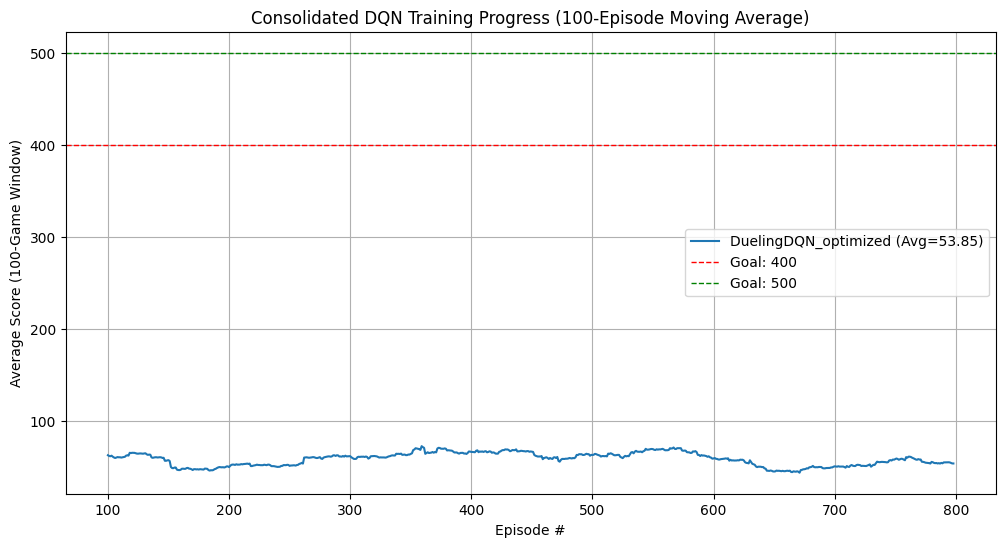

In [94]:
# Run run AFTER you have completed at least one training run
try:
    # Load saved scores (if they exist from previous runs)
    scores_path = '/content/drive/MyDrive/DQN_Checkpoints/dqn_project_scores.npy'
    loaded_scores = np.load(scores_path, allow_pickle=True).item()
    plot_all_dqn_scores(loaded_scores)
except FileNotFoundError:
    print("Scores file not found. Run training first.")

## 6. Video Visualization Utility
This function is provided for optional video recording using a trained model's weights.

In [95]:
def render_mp4(videopath: str) -> str:
  """Gets a string containing a b64-encoded version of the MP4 video."""
  import os
  if not os.path.exists(videopath):
      return f"<p>Video file not found at {videopath}. Run a test episode first.</p>"

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;base64,{base64_encoded_mp4}" type="video/mp4"></video>'

def run_and_record(env_id, weights_path, mode, seed=CONFIG['SEED'], num_episodes=1):
    """Runs a specified agent on the environment and records the interaction."""

    # 1. Setup Environment
    # Use the same wrapper stack as training for consistent state representation
    env_render = make_atari_env(env_id, seed=seed)

    # 2. Setup Agent
    action_size = env_render.action_space.n
    state_shape = env_render.observation_space.shape

    # Use the appropriate Agent class
    if mode == "SimpleDQN":
        test_agent = SimpleDQNAgent(state_shape, action_size, seed)
    elif mode == "DoubleDQN":
        test_agent = DoubleDQNAgent(state_shape, action_size, seed)
    elif mode == "DuelingDQN":
        test_agent = DuelingDQNAgent(state_shape, action_size, seed)
    else:
        return f"<p>Invalid MODE specified for testing: {mode}</p>"

    # 3. Load Weights
    try:
        test_agent.qnetwork_local.load_state_dict(torch.load(weights_path, map_location=device))
        test_agent.qnetwork_local.eval()
        print(f"Successfully loaded {mode} weights from {weights_path}")
    except FileNotFoundError:
        print(f"Checkpoint file {weights_path} not found. Agent will use random weights.")
        return

    # 4. Record Episodes
    video_path = f'{mode}_{env_id.split("/")[-1]}_test.mp4'
    frames = []

    for episode in range(num_episodes):
        state, info = env_render.reset(seed=seed)
        score = 0
        done = False

        while not done:
            # The FrameStack wrapper returns a LazyFrame, convert to NumPy array
            state_np = np.array(state)
            action = test_agent.act(state_np, eps=0.0)

            # Capture frame (convert to RGB before saving)
            frames.append(env_render.render())

            next_state, reward, terminated, truncated, info = env_render.step(action)
            done = terminated or truncated
            state = next_state
            score += reward

        print(f"Test Episode {episode+1} score: {score:.2f}")

    env_render.close()

    # Save video
    imageio.mimsave(video_path, frames, fps=30)

    # Display video
    html = render_mp4(video_path)
    ipythondisplay.display(ipythondisplay.HTML(html))


In [96]:
# Example usage (Uncomment and update weights_path after training):
# run_and_record(CONFIG['ENV_ID'], '/content/drive/MyDrive/DQN_Checkpoints/SimpleDQN_BEST.pth', 'SimpleDQN', num_episodes=1)